In [1]:
!pip install torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0

     |████████████████████████████████| 831.4 MB 2.6 kB/s 
     |████████████████████████████████| 22.1 MB 323 kB/s 
     |████████████████████████████████| 1.9 MB 69.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: Operation cancelled by user


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision import io
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


## Load the data
* Source of the data: https://github.com/lindawangg/COVID-Net
* I've taken the data from: https://drive.google.com/drive/folders/10PIW4rpVU8AETpNDZpyxPmJo00vOwJE7
* The data were gathered by Dominik Chodounský for his bachelor thesis: https://dspace.cvut.cz/handle/10467/95031

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [4]:
!jar xvf gdrive/MyDrive/Diploma/COVIDx8B.zip

Výstupní stream byl oříznut na posledních 5000 řádků.
 inflated: COVIDx8B/train/negative/c8f8c1af-28f3-420d-85d6-9501a8002097.png
 inflated: COVIDx8B/train/negative/c907dcd1-6011-430b-9515-009900b4a98f.png
 inflated: COVIDx8B/train/negative/c90a1623-b7a2-443b-a20c-a3915df8dac2.png
 inflated: COVIDx8B/train/negative/c90ba168-4d65-4205-90e5-4f96d693d54a.png
 inflated: COVIDx8B/train/negative/c90cbfe6-d98f-407b-b3c2-45b27fd1ae72.png
 inflated: COVIDx8B/train/negative/c919262d-e632-4d1b-9d92-7a8923258ae3.png
 inflated: COVIDx8B/train/negative/c91c57aa-ced9-4499-a231-36b78e5fa786.png
 inflated: COVIDx8B/train/negative/c91c84ab-e310-43fb-adfb-9d351786b01f.png
 inflated: COVIDx8B/train/negative/c93f9fee-9ad2-43a8-9071-ba769cbbdf8a.png
 inflated: COVIDx8B/train/negative/c9449bea-76b0-42e0-827b-2677f6c2f1c8.png
 inflated: COVIDx8B/train/negative/c9464c74-1f7f-41a2-a6ac-c72e8afcbb00.png
 inflated: COVIDx8B/train/negative/c94652f9-22cd-48d2-bb01-5f54abbb7d72.png
 inflated: COVIDx8B/train/negative

In [5]:
!rm -rf 'COVIDx8B/train/negative/.ipynb_checkpoints'

In [6]:
import sys
sys.path.append('gdrive/MyDrive/Diploma')
import image_preprocessing

## Prepare the dataset in the pytorch format

In [7]:
ROOT_PATH = 'COVIDx8B'
TRAIN_DIR = os.path.join(ROOT_PATH, 'train')
TEST_DIR = os.path.join(ROOT_PATH, 'test')

img_size = (224, 224)

In [8]:
class Covidx8bDataset(Dataset):
  def __init__(self, img_dir, transform=None):
    self.img_paths = [os.path.join(img_dir, 'negative') + '/' + img_file for img_file in os.listdir(os.path.join(img_dir, 'negative'))] \
                     + [os.path.join(img_dir, 'positive') + '/' + img_file for img_file in os.listdir(os.path.join(img_dir, 'positive'))] 
    self.img_labels = np.concatenate((np.full(shape=(len(os.listdir(os.path.join(img_dir, 'negative'))), ), fill_value=0), 
                                      np.full(shape=(len(os.listdir(os.path.join(img_dir, 'positive'))), ), fill_value=1)))
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    image = Image.open(img_path).convert('RGB')
    label = self.img_labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

## Preprocessing
* resize to 224x224
* convert to pytorch tensor
* use contrast limited adaptive histogram equalization (CLAHE) with 40 clip limits

In [9]:
class CLAHE(object):
  def __call__(self, img):
    img = 255 * np.array(img.permute(1, 2, 0))
    _, new_img = image_preprocessing.rgb_clahe(img, clip_limit=40)
    back2tensor = transforms.ToTensor()

    return back2tensor(new_img)

In [10]:
transform = transforms.Compose([
  transforms.Resize((img_size[0], img_size[1])),
  transforms.ToTensor(),
  CLAHE(),
  #transforms.Normalize(train_mean, train_std)                         
])

In [11]:
#train_data = Covidx8bDataset(TRAIN_DIR, transform=transform)
train_data, val_data = torch.utils.data.random_split(Covidx8bDataset(TRAIN_DIR, transform=transform), [13000, 2952], generator=torch.Generator().manual_seed(1))
test_data = Covidx8bDataset(TEST_DIR, transform=transform)
print(f'train data len = {len(train_data)}')
print(f'val data len = {len(val_data)}')
print(f'test data len = {len(test_data)}')

train data len = 13000
val data len = 2952
test data len = 400


In [12]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

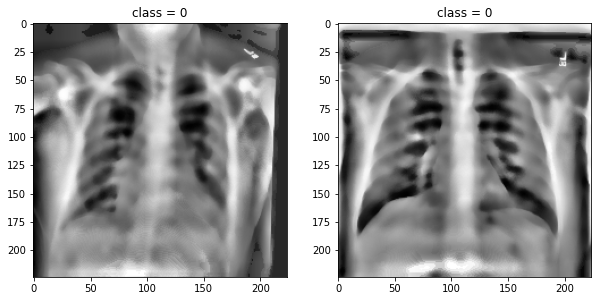

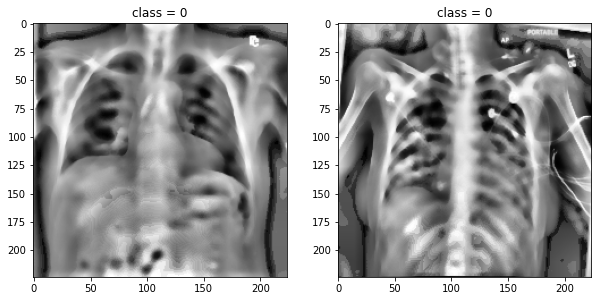

In [13]:
loader = DataLoader(train_data, batch_size=100, num_workers=1, shuffle=True)
batch = next(iter(loader))

for k in range(2):  
  fig, ax = plt.subplots(1,2,figsize=(10,8))
  for i in range(2):
    j = np.random.randint(64)
    ax[i].imshow(batch[0][j].permute(1, 2, 0))
    ax[i].set_title('class = ' + str(batch[1][j].item()))

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
from sklearn.utils.class_weight import compute_class_weight
train_class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_data.dataset.img_labels[train_data.indices]) ,dtype=torch.float).to(device)
print(train_class_weights)

tensor([0.5781, 3.6995], device='cuda:0')


In [18]:
%%capture
!pip install timm
import timm

In [19]:
model_name = 'vit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [21]:
epochs = 20
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    for data, labels in train_dataloader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        target = model(data)
        loss = criterion(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    for data, labels in val_dataloader:
      data, labels = data.to(device), labels.to(device)  
      target = model(data)
      loss = criterion(target,labels)
      valid_loss = loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(val_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'gdrive/MyDrive/Diploma/model_weights/vit_save.pth')

Epoch 1 		 Training Loss: 0.22644789076664232 		 Validation Loss: 0.018611183730504847
Validation Loss Decreased(inf--->1.730840) 	 Saving The Model
Epoch 2 		 Training Loss: 0.14591572803264388 		 Validation Loss: 0.027617198164745043
Epoch 3 		 Training Loss: 0.12583914330441973 		 Validation Loss: 0.0004863470632542846
Validation Loss Decreased(1.730840--->0.045230) 	 Saving The Model
Epoch 4 		 Training Loss: 0.10846502568483517 		 Validation Loss: 0.048066595549224524
Epoch 5 		 Training Loss: 0.0892943495100665 		 Validation Loss: 0.00033868757146661
Validation Loss Decreased(0.045230--->0.031498) 	 Saving The Model
Epoch 6 		 Training Loss: 0.08349815528539921 		 Validation Loss: 0.026069853895453996
Epoch 7 		 Training Loss: 0.0681922343388015 		 Validation Loss: 0.012129484966237059
Epoch 8 		 Training Loss: 0.07151255161932196 		 Validation Loss: 0.022940071680212535
Epoch 9 		 Training Loss: 0.08139844091259052 		 Validation Loss: 0.00913027153220228
Epoch 10 		 Training Los

In [22]:
model.eval()

for text, dataloader in [('train', train_dataloader), ('val', val_dataloader), ('test', test_dataloader)]:
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the {total} {text} images: {100 * correct / total}')

Accuracy of the network on the 13000 train images: 99.41538461538461
Accuracy of the network on the 2952 val images: 95.76558265582656
Accuracy of the network on the 400 test images: 90.0


In [23]:
model_name = 'vit_base_patch16_224'
model2 = timm.create_model(model_name, pretrained=True, num_classes=2)
model2.load_state_dict(torch.load('gdrive/MyDrive/Diploma/model_weights/vit_save.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

model2.eval()

for text, dataloader in [('train', train_dataloader), ('val', val_dataloader), ('test', test_dataloader)]:
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = model2(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the {total} {text} images: {100 * correct / total}')

Accuracy of the network on the 13000 train images: 99.6076923076923
Accuracy of the network on the 2952 val images: 96.2059620596206
Accuracy of the network on the 400 test images: 88.0
